<a href="https://colab.research.google.com/github/martinloretzzz/vector-index-layer/blob/main/IVFIndex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install hnswlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hnswlib: filename=hnswlib-0.8.0-cp310-cp310-linux_x86_64.whl size=2360790 sha256=a5bef285b3910a30930d0920f7fb5beebcc0a45ceeb2c62701342f163ec7612f
  Stored in directory: /root/.cache/pip/wheels/af/a9/3e/3e5d59ee41664eb31a4e6de67d1846f86d16d93c45f277c4e7
Successfully built hnswlib


In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import hnswlib
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.cluster import BisectingKMeans
import time
import timeit
import functools

In [4]:
model_name = "gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

input_text = "The quick brown fox"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

output = model.generate(
    input_ids,
    max_length=50,
    return_dict_in_generate=True,
    output_hidden_states=True,
    output_scores=True,
    output_logits=True
)

gen_tokens = output.sequences

gen_text = tokenizer.batch_decode(gen_tokens)[0]
print(gen_text)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


The quick brown foxes are a great way to get a little bit of a kick out of your dog.

The quick brown foxes are a great way to get a little bit of a kick out of your dog. The quick brown fox


In [5]:
pos = -1

hidden = output.hidden_states
logits = output.logits

last_hidden = hidden[pos][-1].squeeze(0)
last_logits = logits[pos]

print(len(hidden), len(logits), len(hidden[pos]))
print(last_hidden.shape)
print(last_logits.shape)

46 46 13
torch.Size([1, 768])
torch.Size([1, 50257])


In [6]:
topk_values, topk_indices = torch.topk(last_logits, k=100)
print(topk_values)
print(topk_indices)

tensor([[-16.7025, -22.2096, -22.3336, -22.7295, -22.7990, -23.0965, -23.2275,
         -23.3474, -23.4601, -23.4611, -23.4778, -23.5370, -23.5772, -23.5819,
         -23.6171, -23.6674, -23.7671, -23.8119, -23.8334, -23.8356, -23.8740,
         -23.8971, -24.1396, -24.1470, -24.1580, -24.1917, -24.2041, -24.2178,
         -24.2220, -24.2435, -24.2504, -24.3074, -24.3531, -24.4168, -24.5043,
         -24.5263, -24.5277, -24.5595, -24.5778, -24.6051, -24.6493, -24.6613,
         -24.6913, -24.7223, -24.7263, -24.7284, -24.7514, -24.7763, -24.8248,
         -24.8317, -24.8967, -24.9083, -24.9423, -24.9645, -24.9647, -24.9680,
         -24.9755, -24.9959, -25.0300, -25.0372, -25.0406, -25.0551, -25.1007,
         -25.1095, -25.1285, -25.1436, -25.1457, -25.1513, -25.1580, -25.1585,
         -25.1588, -25.1593, -25.1691, -25.1896, -25.1968, -25.2389, -25.2631,
         -25.2643, -25.2779, -25.2887, -25.2937, -25.2961, -25.3075, -25.3221,
         -25.3432, -25.3594, -25.3644, -25.3904, -25

In [7]:
# TODO run kmeans inside cluster to get more specific centroids
def limit_cluster_to_size(labels, centroids, max_cluster_size):
    n_labels, n_centorids = [], []
    new_clusters, new_clusters_count = {}, {}

    for l in labels.tolist():
        if l not in new_clusters or new_clusters_count[l] >= max_cluster_size:
            new_cluster = len(n_centorids)
            n_centorids.append(centroids[l])
            new_clusters[l] = new_cluster
            new_clusters_count[l] = 0

        n_labels.append(new_clusters[l])
        new_clusters_count[l] += 1

    return torch.tensor(n_labels, dtype=torch.int32), torch.stack(n_centorids)


def get_cluster_indices_padded(labels, max_cluster_size):
    cluster_count = len(torch.unique(labels))
    cluster_arange = torch.arange(len(labels))
    emb_from_centroid = torch.full((cluster_count, max_cluster_size), -1, dtype=torch.int32)

    for cluster_id in range(cluster_count):
        cluster_data = cluster_arange[labels == cluster_id]
        emb_from_centroid[cluster_id, :len(cluster_data)] = cluster_data
    return emb_from_centroid

kmeans_cache = {}
def kmeans(x, n_centroids):
    if n_centroids in kmeans_cache:
        return kmeans_cache[n_centroids]

    bkmeans = BisectingKMeans(n_clusters=n_centroids, random_state=42)
    labels = torch.from_numpy(bkmeans.fit_predict(x))
    centroids = torch.from_numpy(bkmeans.cluster_centers_).to(torch.float32)

    kmeans_cache[n_centroids] = labels, centroids
    return labels, centroids

In [8]:
class VectorIndexEmbedding():
    def __init__(self, weight, k, n_centroids, n_search, max_cluster_size):
        self.n_centroids, self.n_search, self.k, self.max_cluster_size = n_centroids, n_search, k, max_cluster_size
        self.weight = weight

        # TODO: try normalize with "normal" kmeans
        weight_norm = weight # F.normalize(weight, p=2, dim=-1)

        # TODO: Inner product distance, normalize?
        labels, centroids = kmeans(weight_norm, n_centroids)
        self.t_labels = labels
        # centroids = F.normalize(centroids, p=2, dim=-1)
        self.labels, self.centroids = limit_cluster_to_size(labels, centroids, max_cluster_size)
        self.cluster_indices = get_cluster_indices_padded(self.labels, max_cluster_size)


    def forward(self, x):
        # TODO batching
        x_norm = x # F.normalize(x.squeeze(0), p=2, dim=-1)

        cluster_logits = x_norm @ self.centroids.T
        topk_cluster_idx = torch.topk(cluster_logits, k=self.n_search)[1]
        emb_idx = self.cluster_indices[topk_cluster_idx].view(-1)
        weight_selected = self.weight[emb_idx]

        logits_selected = x.squeeze(0) @ weight_selected.T
        # TODO: handle out of bound, nan values
        # logits_selected[emb_idx == -1] = -float('inf')
        logits_values, logits_indices_cluster = torch.topk(logits_selected, self.k)
        return logits_values, emb_idx[logits_indices_cluster]

In [9]:
class HNSWIndexEmbedding():
    def __init__(self, weight, k, M=32, ef=100, ef_construction=100):
        self.k = k
        xd, d = weight.shape
        self.index = hnswlib.Index(space='ip', dim=d)
        self.index.init_index(max_elements=xd, ef_construction=ef_construction, M=M)
        self.index.set_ef(ef)
        self.index.add_items(weight.numpy())

    def forward(self, x):
        indices, distances = self.index.knn_query(x, k=self.k)
        return 1 - distances, indices

In [21]:
k = 50

out_emb_weight = model.transformer.wte.weight.detach().clone()
print(out_emb_weight.shape)

out_emb_vector = VectorIndexEmbedding(out_emb_weight, k=k, n_centroids=2048, n_search=128, max_cluster_size=32)
# out_emb_vector = HNSWIndexEmbedding(out_emb_weight, k=k)
# print(len(out_emb_vector.centroids))

torch.Size([50257, 768])


In [22]:
out_logits, out_indices = out_emb_vector.forward(last_hidden)
out_logits, out_indices

(tensor([-16.7025, -22.2096, -22.3336, -22.7295, -22.7990, -23.2275, -23.3474,
         -23.4601, -23.4611, -23.4778, -23.5370, -23.5772, -23.5819, -23.6171,
         -23.6674, -23.8334, -23.8356, -23.8740, -23.8971, -24.1396, -24.1470,
         -24.1580, -24.1917, -24.2041, -24.2178, -24.2220, -24.2435, -24.3531,
         -24.4168, -24.5043, -24.5263, -24.5277, -24.5595, -24.5778, -24.6051,
         -24.6493, -24.6613, -24.6913, -24.7223, -24.7263, -24.7284, -24.7763,
         -24.8248, -24.8317, -24.8967, -24.9645, -24.9647, -24.9755, -24.9959,
         -25.0300]),
 tensor([21831, 17481,  3290,  6844,  7586, 33039,   318, 23214,  3797,   279,
           290, 13209, 22746,  3392,  9230,  1125,    12,   443,    11, 11875,
         13062,   269,  2330, 33043, 13617, 20096,   285,   275, 15900,   277,
          6473,  2951, 10693,   479,   393, 26241,   460,  2042, 34003, 13791,
           686,  5104,  4257,  7540, 10211,  3013,   582,   304,   389,  8701],
        dtype=torch.int32))

In [23]:
# TODO measure on the GPU

# out_emb_vector.index.set_ef(150)

forward_time = timeit.timeit(lambda: out_emb_vector.forward(last_hidden), number=100)
forward_ref_time = timeit.timeit(lambda: last_hidden.squeeze(0) @ out_emb_weight.T, number=100)

print(f"Average time taken (forward): {forward_time:.6f} seconds")
print(f"Average time taken (matrix multiplication): {forward_ref_time:.6f} seconds")
print(f"Speedup: {forward_ref_time / forward_time:.4f}")

Average time taken (forward): 0.649276 seconds
Average time taken (matrix multiplication): 1.331519 seconds
Speedup: 2.0508


In [24]:
positions = range(len(hidden))
# positions = [6]
k_options = [50] # [1, 3, 5, 10, 50]

for pos in positions:
    last_layer_hidden = hidden[pos][-1].squeeze(0)[0,:]
    last_layer_logits = logits[pos].squeeze(0)
    position_topk_indices = torch.topk(last_layer_logits, k)[1]

    exp_logits = torch.exp(last_layer_logits.to(torch.float64))

    token_id = position_topk_indices[0]
    token = tokenizer.decode(token_id)

    out_logits, out_indices = out_emb_vector.forward(last_layer_hidden)
    for j in k_options:
        common_indices = torch.tensor([i for i in position_topk_indices.squeeze(0).tolist()[0:j] if i in out_indices.squeeze(0).tolist()], dtype=torch.int32)

        exp_logits_all = exp_logits[position_topk_indices.squeeze(0)[0:j]]
        exp_logits_common = exp_logits[common_indices]
        logits_percentage = exp_logits_common.sum() / exp_logits_all.sum()
        color = "\033[33m" if logits_percentage < 0.8 else ""

        print(f"{color}{pos}: {len(common_indices)}/{j} ({len(common_indices)/j:0.2f}), logits: {logits_percentage:0.4f}, {token} {token_id}\033[0m")
    if len(k_options) > 1: print()

    if len(positions) == 1:
        print(exp_logits_common / exp_logits_all.sum())

0: 14/50 (0.28), logits: 0.3888, es 274
1: 49/50 (0.98), logits: 0.9914,  are 389
2: 50/50 (1.00), logits: 1.0000,  a 257
3: 44/50 (0.88), logits: 0.9396,  great 1049
4: 46/50 (0.92), logits: 0.9608,  way 835
5: 48/50 (0.96), logits: 0.9999,  to 284
6: 46/50 (0.92), logits: 0.9616,  get 651
7: 46/50 (0.92), logits: 0.9564,  a 257
8: 39/50 (0.78), logits: 0.8796,  little 1310
9: 41/50 (0.82), logits: 0.9267,  bit 1643
10: 45/50 (0.90), logits: 0.9948,  of 286
11: 43/50 (0.86), logits: 0.9158,  a 257
12: 32/50 (0.64), logits: 0.7685,  kick 4829
13: 49/50 (0.98), logits: 0.9957,  out 503
14: 49/50 (0.98), logits: 1.0000,  of 286
15: 45/50 (0.90), logits: 0.9819,  your 534
16: 40/50 (0.80), logits: 0.8551,  dog 3290
17: 48/50 (0.96), logits: 0.9935, . 13
18: 27/50 (0.54), logits: 0.6746, 
 198
19: 47/50 (0.94), logits: 0.9998, 
 198
20: 48/50 (0.96), logits: 0.9728, The 464
21: 42/50 (0.84), logits: 0.9263,  quick 2068
22: 41/50 (0.82), logits: 0.9981,  brown 7586
23: 41/50 (0.82), logits:

tensor([32, 32, 32,  ...,  1,  1,  1])


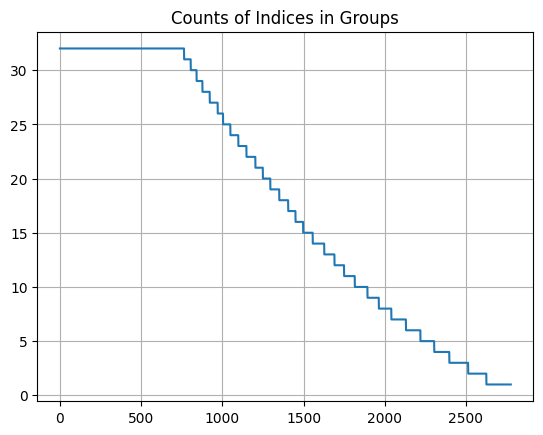

In [25]:
if True:
    counts = torch.unique(out_emb_vector.labels, return_counts=True)[1]
    counts = torch.sort(counts, descending=True)[0]

    print(counts)
    plt.plot(range(len(counts)), counts)
    plt.title("Counts of Indices in Groups")
    plt.grid()
    plt.show()